Notebook elaborado para estudar as características relacionadas à assinatura magnetométrica de corpos de diferentes geometrias.
Criado para a disciplina Geofísica II da Universidade Federal de Uberlândia.
O uso e a reprodução são livres para fins educacionais, pede-se apenas a citação da fonte.

[![License: GPL v3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)

Esta demonstração utiliza a modelagem de dados gravimétricos implementados no pacote *open source* [SimPEG v.14.3](https://github.com/simpeg/simpeg) (COCKETT et al., 2015), distribuído sob os termos da [licença MIT](https://github.com/simpeg/simpeg/blob/master/LICENSE). Não foram feitas modificações nos códigos utilizados.


Prof. Dr. Emerson Rodrigo Almeida<br>
Universidade Federal de Uberlândia<br>
Instituto de Geografia - Curso de Geologia<br>
emerson.almeida@ufu.br<br>

<p>&nbsp;</p>
Última modificação: 30/03/2021

---

**Referência:**

COCKETT, R.; KANG, S.; HEAGY, L. J.; PIDLISECKY, A.; OLDENBURG, D. W. SimPEG: An open source framework for simulation and gradient based parameter estimation in geophysical applications. **Computers & Geosciences**, v.85, Part A, p. 142-154, 2015.

# Instruções iniciais

Neste notebook você irá visualizar a anomalia Bouguer em regiões específicas do mundo. Para isto leia atentamente as instruções apresentadas antes de cada célula e execute-as uma a uma, para acompanhar o processo corretamente.

Não se preocupe em compreender o código em si, não é obrigatório que você conheça a programação para obter e interpretar os resultados da demonstração. Mesmo assim, sinta-se livre caso queira perguntar qualquer coisa para aprender mais sobre o código e sua elaboração.

<p>&nbsp;</p>

### Passo 01 - Preparação

Primeiramente vamos preparar o ambiente para a execução da demonstração. Será preciso instalar o [SimPEG](https://simpeg.xyz/), que é um pacote open source para modelagem de dados geofísicos. Se você estiver executando este notebook pelo Binder ou pelo Colab execute a célula abaixo para instalar o SimPEG remotamente. Se preferir, pode instalar o pacote diretamente no seu computador ([instruções aqui](https://docs.simpeg.xyz/content/basic/installing.html)) e excluir a célula, porém é recomendável que faça isso **SOMENTE** se você já tiver familiaridade com este tipo de procedimento para evitar qualquer problema.

Você pode executar o código na célula clicando sobre ela e em seguida clicando no botão **RUN** na barra do Jupyter Notebook ou pressionando as teclas **SHIFT+ENTER** no seu teclado. Se você preferir executar este notebook localmente, no seu computador, então exclua a célula abaixo para não afetar a sua instalação.

# importa e instala o SimPEG - Célula exclusiva para execução em ambiente remoto
# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/04-magnetics/plot_2a_magnetics_induced.html

!git clone https://github.com/simpeg/simpeg
%cd simpeg
!pip install -r requirements.txt
!python setup.py install

Agora importe os módulos e defina as funções que precisaremos no decorrer da demonstração. A célula abaixo contém as funções utilizadas nos cálculos e as funções utilizadas para gerar as figuras. Execute-a uma vez antes de executar qualquer outra parte do código e **não altere nada no código apresentado na célula** para não criar problemas na execução do código.

<p>&nbsp;</p>

**Importante!** Nem todas as células irão retornar algum tipo de mensagem ou figura após a execução. Isto é normal e não significa que a execução tenha falhado. Perceba o símbolo **In [   ]:** próximo ao canto superior esquerdo de cada célula. Ao iniciar a execução de uma delas você verá um asterisco ($*$) aparecer dentro dos colchetes. Você saberá que a execução ocorreu sem problemas quando o $*$ dentro dos colchetes for substituído por um número e nenhuma mensagem de erro aparecer abaixo da célula executada.

In [1]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc
from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps
from SimPEG.potential_fields import magnetics
from SimPEG import utils, data

class modelo():
    
    """
    Define as dimensões, topografia e malha de tensores do modelo
    """
    
    def __init__(self, par_x, par_y, par_z, suscep_bg, topografia=None):
        
        """
        par_x:    parâmetros de comprimento e discretização do eixo x do modelo
        par_y:    parâmetros de comprimento e discretização do eixo y do modelo
        par_z:    parâmetros de comprimento e discretização do eixo z do modelo
        rho_bg:   densidade do background homogêneo
        """
        
        # cria os eixos x, y e z do modelo
        self.xx_m = np.linspace(-1 * par_x[0]/2, par_x[0]/2, 1 + int(par_x[0]/par_x[1]))
        self.yy_m = np.linspace(-1 * par_y[0]/2, par_y[0]/2, 1 + int(par_y[0]/par_y[1]))
        self.zz_m = np.linspace(0.0, par_z[0], 1 + int(par_z[0]/par_z[1]))
        
        
        # densidade das rochas do background - é zero porque o modelo vai considerar só
        # o contraste, não o valor absoluto
        self.suscep_background = suscep_bg
        
        
        # Define a topografia do modelo
        [x_topo, y_topo] = np.meshgrid(self.xx_m, self.yy_m)
        if topografia=='default':
            z_topo = -15.0 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 80 ** 2)

        elif not topografia:
            z_topo = np.zeros((len(self.yy_m), len(self.xx_m)))

        x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
        self.xyz_topo = np.c_[x_topo, y_topo, z_topo]


        # Define a malha de tensores em células de tamanho regular
        dx = self.xx_m[1]-self.xx_m[0]
        dy = self.yy_m[1]-self.yy_m[0]
        dz = self.zz_m[1]-self.zz_m[0]

        nx = int((np.max(self.xx_m)-np.min(self.xx_m))/dx)
        ny = int((np.max(self.yy_m)-np.min(self.yy_m))/dy)
        nz = int((np.max(self.zz_m)-np.min(self.zz_m))/dz)
        
        hx = [(dx, nx)]
        hy = [(dy, ny)]
        hz = [(dz, nz)]

        self.mesh = TensorMesh([hx, hy, hz], 'CCN')
        
        # Find the indices for the active mesh cells (e.g. cells below surface)
        self.ind_active = surface2ind_topo(self.mesh, self.xyz_topo)

        # Define mapping from model to active cells. The model consists of a value for
        # each cell below the Earth's surface.
        nC = int(self.ind_active.sum())
        self.model_map = maps.IdentityMap(nP=nC)

        # Define o modelo com a susceptibilidade do background. Models in SimPEG are vector arrays.
        self.model = self.suscep_background * np.ones(nC)
        
        
    def insere_esfera(self, chi, x, y, z, raio):
        ind_sphere = model_builder.getIndicesSphere([x, y, (z-raio)], raio, self.mesh.gridCC)
        ind_sphere = ind_sphere[self.ind_active]
        self.model[ind_sphere] = chi
        
        
    def insere_bloco(self, chi, vertices):
        """
        vertices: lista de tuplas -> [(xi, xf),(yi, yf),(zi, zf)]
        """
        
       
        ind_block = ((self.mesh.gridCC[self.ind_active, 0] > vertices[0][0])
                    & (self.mesh.gridCC[self.ind_active, 0] < vertices[0][1])
                    & (self.mesh.gridCC[self.ind_active, 1] > vertices[1][0])
                    & (self.mesh.gridCC[self.ind_active, 1] < vertices[1][1])
                    & (self.mesh.gridCC[self.ind_active, 2] > vertices[2][0])
                    & (self.mesh.gridCC[self.ind_active, 2] < vertices[2][1]))
        self.model[ind_block] = chi

        
    def plota_corte(self, direcao, posicao):

        if direcao.upper()=='X':
            indice_slice = np.abs(posicao - self.xx_m).argmin()
        
        if direcao.upper()=='Y':
            indice_slice = np.abs(posicao-self.yy_m).argmin()
            
        if direcao.upper()=='Z':
            indice_slice = np.abs((np.max(np.abs(self.zz_m))-np.abs(posicao))-self.zz_m).argmin()
        
        fig = plt.figure(figsize=(10, 3))
        plotting_map = maps.InjectActiveCells(self.mesh, self.ind_active, np.nan)

        ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
        
        self.mesh.plot_slice(
            plotting_map * np.log10(self.model),
            normal=direcao,
            ax=ax1,
            ind=int(indice_slice),    # ind=int(self.mesh.nCy / 2),
            grid=False,
            clim=(np.min(np.log10(self.model)), np.max(np.log10(self.model))),
            pcolorOpts={"cmap": "viridis"},
        )
        
        ax1.set_title('Corte em ' + direcao.upper() + ' = ' + str(posicao) + ' m')
        
        if direcao=='Y':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='X':
            ax1.set_xlabel('Distância em Y (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='Z':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Distância em Y (m)', fontsize=14)

        ax2 = fig.add_axes([0.85, 0.12, 0.025, 0.78])
        norm = mpl.colors.Normalize(vmin=np.min(np.log10(self.model)), vmax=np.max(np.log10(self.model)))
        cbar = mpl.colorbar.ColorbarBase(
            ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
        )
        cbar.set_label(r"$log_{10}chi \:\: (SI)$", rotation=90, labelpad=15, size=12)

        plt.show()
        
        
class aquisicao():
    
    def __init__(self, mod, f, inc, dec, componente=['tmi']):
    
        """
        Configura os pontos do levantamento no modelo
        
        The user only needs an (N, 3) array to define the xyz locations of the observation locations, 
        and a list of field components which are to be measured.
        
        xx_s:    coordenadas x dos pontos de levantamento
        yy_s:    coordenadas y dos pontos de levantamento
        h_s:     elevação do levantamento
        mod:     objeto da classe modelo
        """
                
        self.xx_s = np.linspace(-1000, 1000.0, 40)
        self.yy_s = np.linspace(-1000.0, 1000.0, 40)
        self.h_s = 0.0
        self.componente = componente
        
        x, y = np.meshgrid(self.xx_s, self.yy_s)

        x = mkvc(x.T)
        y = mkvc(y.T)

        # cria a função de interpolação para o espaço do modelo
        fun_interp = LinearNDInterpolator(np.c_[mod.xyz_topo[:, 0], mod.xyz_topo[:, 1]], mod.xyz_topo[:, 2])

        # interpola as coordenadas das estações e coloca h_s metros acima da superfície
        z = fun_interp(np.c_[x, y]) + self.h_s
        
        self.receiver_locations = np.c_[x, y, z]

        # Use the observation locations and components to define the receivers. To
        # simulate data, the receivers must be defined as a list.
        receiver_list = magnetics.receivers.Point(self.receiver_locations, components=componente)
        self.receiver_list = [receiver_list]

        # Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
        inclination = inc
        declination = dec
        strength = f
        self.inducing_field = (strength, inclination, declination)
        self.source_field = magnetics.sources.SourceField(receiver_list=self.receiver_list, parameters=self.inducing_field)

        # Defining the survey
        self.survey = magnetics.survey.Survey(self.source_field)    # é um objeto
        
        
    def fwd(self, mod):
        
        # Define the forward simulation. By setting the 'store_sensitivities' keyword
        # argument to "forward_only", we simulate the data without storing the sensitivities
        simulation = magnetics.simulation.Simulation3DIntegral(
                        survey = self.survey,
                        mesh = mod.mesh,
                        chiMap = mod.model_map,
                        actInd = mod.ind_active,
                        store_sensitivities = "forward_only",
        )

        # Compute predicted data for some model
        self.dpred = simulation.dpred(mod.model)
        self.descricao = 'Intensidade Total (TMI)'
       
        
    def plota_mapa(self, coordenadas=[0.0, 0.0]):
        nx = len(self.xx_s)
        ny = len(self.yy_s)

        matriz_dados = np.reshape(self.dpred, [ny, nx])
        ind_x = np.abs(self.xx_s-coordenadas[0]).argmin()    # índice da coordenada x no eixo x
        ind_y = np.abs(self.yy_s-coordenadas[1]).argmin()    # índice da coordenada y no eixo y

        fig = plt.figure(figsize=(13, 6))

        plt.subplot(121)
        im = plt.imshow(np.flipud(matriz_dados), extent=[self.xx_s[0], self.xx_s[-1], self.yy_s[0], self.yy_s[-1]], \
                        cmap='jet_r', vmin=np.min(matriz_dados), vmax=np.max(matriz_dados), interpolation='bicubic')
        plt.plot([coordenadas[0], coordenadas[0]], [self.xx_s[0], self.xx_s[-1]], '--w')
        plt.plot([self.yy_s[0], self.yy_s[-1]], [coordenadas[1], coordenadas[1]], '--w')
        plt.colorbar(im, label='nT', shrink=0.75)
        plt.xlabel('Distância em X (m)', fontsize=14)
        plt.ylabel('Distância em Y (m)', fontsize=14)
        plt.title(self.descricao, fontsize=14)
        
        # para excluir os efeitos de borda da modelagem
        l_x = self.xx_s[-1] - self.xx_s[0]
        l_y = self.yy_s[-1] - self.yy_s[0]
        plt.xlim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        plt.ylim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        
        plt.subplot(222)
        plt.plot(self.yy_s, matriz_dados[:, ind_x])
        plt.title('Perfil N-S cruzando a anomalia em X='+ str(coordenadas[0]) +' m', fontsize=14)
        plt.xlabel('Distância em Y (m)', fontsize=14)
        plt.ylabel('Anomalia (nT)', fontsize=14)
        plt.xlim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        plt.grid()

        plt.subplot(224)
        plt.plot(self.xx_s, matriz_dados[ind_y,:])
        plt.title('Perfil E-W cruzando a anomalia em Y='+ str(coordenadas[1]) +' m', fontsize=14)
        plt.xlabel('Distância em X (m)', fontsize=14)
        plt.ylabel('Anomalia (nT)', fontsize=14)
        plt.xlim([self.xx_s[0]+(l_x/7), self.xx_s[-1]-(l_x/7)])
        plt.grid()

        plt.tight_layout()
        plt.show()
        
        
def esfera(r, z, chi, eixo_x = [2000.0, 40.0], eixo_y = [2000.0, 40.0], eixo_z = [400.0, 20.0]):
    """
    eixo_x = [2000.0, 40.0]      # [comprimento, delta]
    eixo_y = [2000.0, 40.0]      # [comprimento, delta]
    eixo_z = [400.0, 20.0]       # [comprimento, delta]
    """
    
    modelo_atual = modelo(eixo_x, eixo_y, eixo_z, 1e-5)
    modelo_atual.insere_esfera(chi, 0.0, 0.0, z, r)
    
    return modelo_atual
    

def cubo(l, z, chi, eixo_x=[2000.0, 40.0], eixo_y=[2000.0, 40.0], eixo_z=[400.0, 20.0]):
    """
    eixo_x = [2000.0, 40.0]      # [comprimento, delta]
    eixo_y = [2000.0, 40.0]      # [comprimento, delta]
    eixo_z = [400.0, 20.0]       # [comprimento, delta]
    """
    
    modelo_atual = modelo(eixo_x, eixo_y, eixo_z, 1e-5)
    modelo_atual.insere_bloco(chi, [(-l/2.0, l/2.0), (-l/2.0, l/2.0), (z-l, z)])
    
    return modelo_atual


def dique(l, z, chi, eixo_x=[2000.0, 40.0], eixo_y=[2000.0, 40.0], eixo_z=[400.0, 20.0]):
    """
    eixo_x = [2000.0, 40.0]      # [comprimento, delta]
    eixo_y = [2000.0, 40.0]      # [comprimento, delta]
    eixo_z = [400.0, 20.0]       # [comprimento, delta]
    """
    
    modelo_atual = modelo(eixo_x, eixo_y, eixo_z, 1e-5)
    modelo_atual.insere_bloco(chi, [(-l/2.0, l/2.0), (-1000.0, 1000.0), (-400, z)])
    
    return modelo_atual


def sill(l, h, z, chi, eixo_x=[2000.0, 40.0], eixo_y=[2000.0, 40.0], eixo_z=[400.0, 20.0]):
    """
    eixo_x = [2000.0, 40.0]      # [comprimento, delta]
    eixo_y = [2000.0, 40.0]      # [comprimento, delta]
    eixo_z = [400.0, 20.0]       # [comprimento, delta]
    """
    
    modelo_atual = modelo(eixo_x, eixo_y, eixo_z, 1e-5)
    modelo_atual.insere_bloco(chi, [(-l/2.0, l/2.0), (-1000.0, 1000.0), (z-h, z)])
    
    return modelo_atual

### Passo 02 - Configuração do campo geomagnético

A assinatura de uma anomalia magnética está sujeita às características de inclinação, declinação e intensidade do campo geomagnético na região onde a aquisição é feita, de forma que a anomalia observada sobre um mesmo corpo pode apresentar comportamentos diferentes em diferentes locais do mundo. Como padrão iremos definir as características do campo geomagnético nas coordenadas onde encontra-se o campus da Universidade Federal de Uberlândia em Monte Carmelo (latitude = -18.723889°, longitude = -47.523889°, altitude = 890.0 m) no dia 30/03/2021, data em que este notebook foi redigido. Características destas componentes para outras localidades podem ser obtidas a partir do [cálculo do IGRF](https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm).

Execute a célula abaixo para configurar estas características.

In [2]:
intensidade = 23170.0      # intensidade total em nT
inclinacao = -32.9445      # inclinação em graus
declinacao = -21.8288      # declinação em graus

### Passo 03 - Anomalia causada por corpos de geometria simples

Primeiramente será configurado um corpo de forma esférica a uma profundidade de 50.0 metros, com raio igual a 150.0 m. Execute a célula abaixo para configurar este corpo.

In [3]:
# meu_modelo = esfera(r=150.0, z=-50.0, chi=1e-2)
# meu_modelo = cubo(l=300.0, z=-50.0, chi=1e-2)
# meu_modelo = dique(l=50.0, z=-50.0, chi=1e-2)
meu_modelo = sill(l=800.0, h=50.0, z=-50.0, chi=1e-2)

Execute a célula abaixo para exibir vistas em corte do modelo nas três direções.

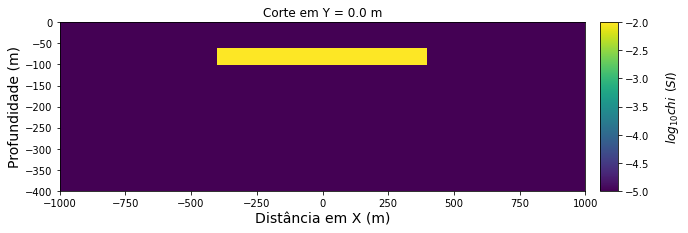

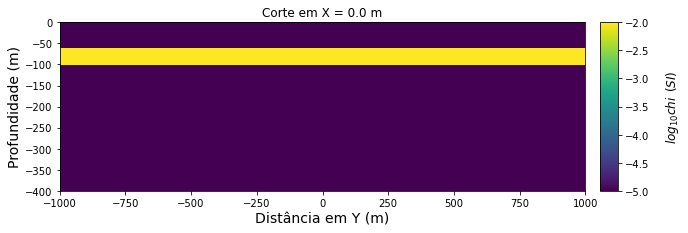

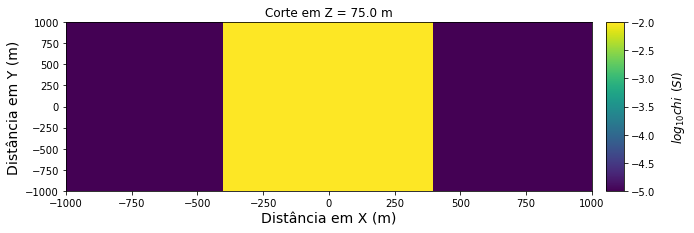

In [4]:
meu_modelo.plota_corte('Y', 0.0)
meu_modelo.plota_corte('X', 0.0)
meu_modelo.plota_corte('Z', 75.0)

Uma vez verificada a geometria do modelo com o corpo desejado, execute a célula abaixo para executar a simulação da aquisição em uma malha de pontos localizada na superfície do modelo (i.e., à elevação de 0.0 m).

In [5]:
minha_aquisicao = aquisicao(meu_modelo, f=intensidade, inc=inclinacao, dec=declinacao)
%time minha_aquisicao.fwd(meu_modelo)

Wall time: 2min 42s


Por fim, execute a célula abaixo para obter o mapa de intensidade magnética total referente ao modelo configurado. Os valores numéricos entre os colchetes correspondem às posições dos perfis indicados no mapa (linhas tracejadas brancas) e mostradas à direita na figura. Você pode modificá-los, caso deseje.

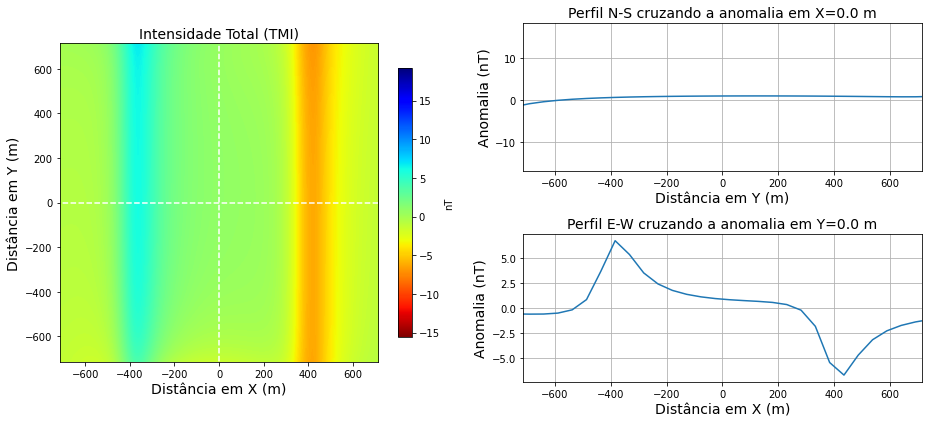

In [6]:
minha_aquisicao.plota_mapa([0.0, 0.0])

### Passo 04 - Alterando a geometria do corpo

Agora você poderá configurar corpos de outras formas geométricas e verificar como a assinatura da anomalia se comporta. Para executar esta operação, escolha um dos modelos da tabela abaixo, copie a linha de código correspondente e cole-a na primeira célula do Passo 03, substituindo totalmente a linha presente nesta célula.




forma cúbica também a uma profundidade de 50.0 metros, e com comprimento de arestas igual a 300.0 m. Execute a célula abaixo para configurar este corpo.

# corpo cúbico (delta_rho, [(xi, xf),(yi, yf),(zi, zf)])
#meu_modelo.insere_bloco(1e-1, [(-450, -150), (150, 450), (-350, -50)])

# embasamento (delta_rho, [(xi, xf),(yi, yf),(zi, zf)])
#meu_modelo.insere_bloco(1e-1, [(-1000, 1000), (-1000, 1000), (-260, -140)])

# dique na direção N-S (delta_rho, [(xi, xf),(yi, yf),(zi, zf)])
#meu_modelo.insere_bloco(1e-1, [(200, 300), (-1000, 1000), (-260, -140)])